<a href="https://colab.research.google.com/github/RamyaGuru/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/ALIGNN_example_AIMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atomistic Line Graph Neural Network (ALIGNN)

The ALIGNN framework (reference [paper](https://www.nature.com/articles/s41524-021-00650-1/)) is used to encode crystal structure information in graph representations which then interfaces with a message passing neural network. This neural network framework can update the embeddings of nodes and edges in the graph while retaining graph connectivity and allowing neighboring nodes and edges to exchange information (pass messages) about their state.

# Table of contents

1. Installing [ALIGNN](https://github.com/usnistgov/alignn)
2. Training [JARVIS-DFT](https://jarvis.nist.gov/jarvisdft) 2D exfoliation energy model 
5. Using trained models to make fast predictions for compounds with unknown exfoliation energies

In [14]:
!pip install alignn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import os
!pwd
os.chdir('/content')
# Clone ALIGNN repo to get example folder
if not os.path.exists('alignn'):
  !git clone https://github.com/usnistgov/alignn.git

os.chdir('alignn')
# Install using setup.py in case pip didn't work
# !python setup.py develop

!pip install dgl-cu111 # Colab has cuda 11.1

/content/alignn/DataDir_ExfoEnergy/DataDir_ExfoEnergy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Train a model for JARVIS-DFT Exfoliation energy

**Get data in id_prop.csv format**

Here, we will organize the data used for training and validation into the appropriate format to train the ALIGNN model. 

The data is collected here from the Jarvis-DFT 3D dataset, which contains the relaxed structures and computed material properties for over 55,000 materials. 

The training data should be formatted as a simple CSV file listing the structure file for the sample (e.g. POSCAR-JVASP-10.vasp) and then the target property value. Example format:

``POSCAR-JVASP-10.vasp,71.12950718943668``

``POSCAR-JVASP-1372.vasp,44.54199597616097``  

``POSCAR-JVASP-14873.vasp,110.43563937368668``

**Try modifying**

Change ``prop`` from ``exfoliation energy`` to another property in the JARVIS-DFT 3D database. 

In [16]:
from jarvis.db.figshare import data as jdata
from jarvis.core.atoms import Atoms
import os

cwd = os.getcwd() #current working directory
temp_dir_name = "DataDir_ExfoEnergy" 

if not os.path.isdir(temp_dir_name):
  os.makedirs(temp_dir_name)
os.chdir(temp_dir_name)

#Load JARVIS-DFT 3D Dataset
dft_3d = jdata("dft_3d")

#List all properties for first entry
dft_3d[0].keys()


Obtaining 3D dataset 55k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Loading the zipfile...
Loading completed.


dict_keys(['jid', 'spg_number', 'spg_symbol', 'formula', 'formation_energy_peratom', 'func', 'optb88vdw_bandgap', 'atoms', 'slme', 'magmom_oszicar', 'spillage', 'elastic_tensor', 'effective_masses_300K', 'kpoint_length_unit', 'maxdiff_mesh', 'maxdiff_bz', 'encut', 'optb88vdw_total_energy', 'epsx', 'epsy', 'epsz', 'mepsx', 'mepsy', 'mepsz', 'modes', 'magmom_outcar', 'max_efg', 'avg_elec_mass', 'avg_hole_mass', 'icsd', 'dfpt_piezo_max_eij', 'dfpt_piezo_max_dij', 'dfpt_piezo_max_dielectric', 'dfpt_piezo_max_dielectric_electronic', 'dfpt_piezo_max_dielectric_ionic', 'max_ir_mode', 'min_ir_mode', 'n-Seebeck', 'p-Seebeck', 'n-powerfact', 'p-powerfact', 'ncond', 'pcond', 'nkappa', 'pkappa', 'ehull', 'dimensionality', 'efg', 'xml_data_link', 'typ', 'exfoliation_energy', 'spg', 'crys', 'density', 'poisson', 'raw_files', 'nat', 'bulk_modulus_kv', 'shear_modulus_gv', 'mbj_bandgap', 'hse_gap', 'reference', 'search'])

In [24]:
#Select property (use different property tag to change prediction)
prop = "exfoliation_energy" #"optb88vdw_bandgap"
f = open("id_prop.csv", "w")

'''
Check each entry in JARVIS-DFT 3D dataset to see if the exfoliation energy is 
defined. If so, include in the id_props dataset. Additionally, write out the 
POSCAR structure file for each entry.
'''
for i in dft_3d:
    atoms = Atoms.from_dict(i["atoms"])
    jid = i["jid"]
    poscar_name = "POSCAR-" + jid + ".vasp"
    target = i[prop]
    if target != "na":
        atoms.write_poscar(poscar_name)
        f.write("%s,%6f\n" % (poscar_name, target))
f.close()

os.chdir(cwd)

In [18]:
#Count how many POSCAR files are in the current directory
!ls -altr  DataDir_ExfoEnergy/*.vasp | wc -l


813


In [19]:
 #Count how many lines are in the id_prop.csv file (should match value above)
 !wc -l DataDir_ExfoEnergy/id_prop.csv 

813 DataDir_ExfoEnergy/id_prop.csv


**run train_folder.py**

In addition to the dataset file (id_prop.csv) a configuration file to describe the essential parameters of the atomistic line graph neural network should be located in the same directory. The configuration file should be formatted as a ``json`` file, and an example file can be found [here](https://github.com/usnistgov/alignn/blob/main/alignn/examples/sample_data/config_example.json).

**Try modifying**

Common attributes to change from default setting may include:

1) Number of epochs: number of cycles used to train the neural network using the entire training set

2) Batch size: number of samples used to train the neural network at once

3) Output features: default is 1 for predicting single, scalar values; adjust if predicting a multi-output quantity

4) ALIGNN layers/ GCN layers: number of ALIGNN update layers or edge-gated graph convolution layers

In [25]:
import time
t1=time.time()
!train_folder.py --root_dir "DataDir_ExfoEnergy" --epochs 50 --batch_size 64 --config "alignn/examples/sample_data/config_example.json" --output_dir="ExfoEnOut"
t2=time.time()
print ('Time in s',t2-t1)

Using backend: pytorch
MAX val: 948.93
MIN val: 0.03
MAD: 62.629814227293544
Baseline MAE: 61.033631528964854
data range 948.93 0.03
  0% 0/650 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/jarvis/core/graphs.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  r = torch.tensor(r).type(torch.get_default_dtype())
100% 650/650 [00:12<00:00, 54.05it/s]
Setting it to max atomic number available here, 103
Setting it to max atomic number available here, 103
Setting it to max atomic number available here, 103
building line graphs
100% 650/650 [00:00<00:00, 910.08it/s]
data range 388.51 18.3
100% 81/81 [00:01<00:00, 59.28it/s]
building line graphs
100% 81/81 [00:00<00:00, 590.70it/s]
data range 903.94 0.95
100% 81/81 [00:02<00:00, 35.71it/s]
building line graphs
100% 81/81

In [27]:
!ls ExfoEnOut	 

checkpoint_49.pt	 mad
checkpoint_50.pt	 prediction_results_test_set.csv
config.json		 prediction_results_train_set.csv
history_train.json	 test_data_data_range
history_val.json	 train_data_data_range
ids_train_val_test.json  val_data_data_range


Here checkpoints are the model parameter files that can be loaded in torch library to make predictions such as [this example](https://github.com/usnistgov/alignn/blob/main/alignn/scripts/predict.py). The checkpoint files can be used to run the trained model on new samples.

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
df = pd.read_csv('/content/alignn/ExfoEnOut/prediction_results_test_set.csv')

These are the predictions for the 10% of the dataset that the model did not see during training and validaiton steps.

In [28]:
df

,id,target,prediction
0,POSCAR-JVASP-12918.vasp,27.170000,322.634399
1,POSCAR-JVASP-2035.vasp,82.290001,89.378479
2,POSCAR-JVASP-13942.vasp,87.809998,50.296844
3,POSCAR-JVASP-278.vasp,144.320007,199.241974
4,POSCAR-JVASP-10173.vasp,33.700001,77.589912
...,...,...,...
76,POSCAR-JVASP-4364.vasp,54.290001,50.641140
77,POSCAR-JVASP-29480.vasp,78.639999,56.020142
78,POSCAR-JVASP-28375.vasp,55.480000,48.084400
79,POSCAR-JVASP-590.vasp,88.519997,85.902924


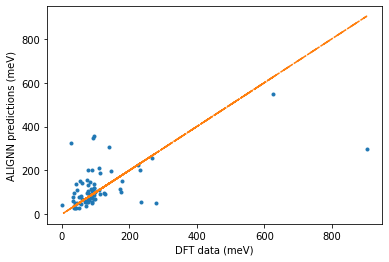

In [29]:
plt.plot(df['target'],df['prediction'],'.')
plt.plot(df['target'],df['target'],'-.')
plt.xlabel('DFT data (meV)')
plt.ylabel('ALIGNN predictions (meV)')
plt.show()

**run model just trained on new samples without exfoliation energies listed**

1. Load the model parameters saved in the final checkpoint file 
2. Fetch the features for 50 samples which do not have exfoliation energies listed on the JARVIS-DFT 3D dataset
3. Run model for prediction on multiple samples using ``get_multiple_predictions``

In [34]:
# Run Trained Model to Predict Values for Compounds without Exfoliation Energy

import torch
from alignn.pretrained import get_multiple_predictions
from alignn.models.alignn import ALIGNN,ALIGNNConfig

if torch.cuda.is_available():
    device = torch.device("cuda") # might have to change to "cpu"


model = ALIGNN(ALIGNNConfig(name="alignn"))
model.load_state_dict(torch.load('ExfoEnOut/checkpoint_50.pt', map_location=device)["model"])
model.to(device)
model.eval()
atoms_array=[]

max_samples = 50
count = 1
for i in dft_3d:
    atoms = Atoms.from_dict(i["atoms"])
    jid = i["jid"]
    poscar_name = "POSCAR-" + jid + ".vasp"
    target = i[prop]
    if target == "na":
        atoms_array.append(atoms)
        count = count + 1
        if count == max_samples:
          break

get_multiple_predictions(atoms_array=atoms_array,model=model)

data range -9999 -9999


100%|██████████| 49/49 [00:01<00:00, 43.77it/s]


building line graphs


100%|██████████| 49/49 [00:00<00:00, 438.84it/s]


These are the exfoliation energy predictions for unlabelled compositions in the JARVIS-DFT 3D dataset.

In [35]:
import pandas as pd
 
pred_df=pd.read_json('pred_data.json')

#Add the chemical formula as a column in the prediction dataframe
cf_list = []
for index, row in pred_df.iterrows():
  atoms = Atoms.from_dict(row["atoms"])
  cf_list.append(atoms.composition.reduced_formula)

pred_df['formula'] = cf_list
pred_df.sort_values('pred',ascending=False)[:10]

,id,atoms,pred,formula
2,2,"{'lattice_mat': [[-1.833590720595598, 1.833590...",536.987610,Be2OsRu
17,17,"{'lattice_mat': [[7.709535704177289, 2.46207e-...",523.069946,SmSb12Os4
24,24,"{'lattice_mat': [[4.084155317570781, -1.066825...",488.474487,Ce2Al16Pt9
48,48,"{'lattice_mat': [[4.086274992215878, 0.0, -0.6...",438.184509,Ce3Si8Ni2
45,45,"{'lattice_mat': [[-0.0, 4.326757913323647, 4.3...",431.418640,Ca4BeW
37,37,"{'lattice_mat': [[-0.0, 5.040771484524319, 5.0...",419.962097,Ba4HgPb
19,19,"{'lattice_mat': [[6.850665464204784, -0.0, 0.0...",410.643097,BaGe2
33,33,"{'lattice_mat': [[0.0, 4.936437902689708, 4.93...",398.381226,Ba4TaZn
41,41,"{'lattice_mat': [[0.0, 5.129874508851702, 5.12...",396.650482,Ba4LiHf
7,7,"{'lattice_mat': [[4.284492173131309, 1.636192e...",370.480347,LuNi4Sn
